In [21]:
import cv2 as cv
import numpy as np
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
from random import shuffle
from tqdm import tqdm

In [22]:
face_detection = cv.CascadeClassifier("harrcascade_face_detection_classifier.xml")
def generate_dataset():
    
    def image_crop(img):
        gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
        faces = face_detection.detectMultiScale(gray,scaleFactor=1.4,minNeighbors=5)
        
        if faces is ():
            return None
        for(x,y,w,h) in faces:
            cropped_face = img[y:y+h,x:x+w]
        return cropped_face
    
    capture = cv.VideoCapture(0)
    img_id = 0
    while True:
        isFrameRead,frame = capture.read()
        if image_crop(frame) is not None:
            img_id+=1
            face = cv.resize(image_crop(frame),(250,250))
            face = cv.cvtColor(face,cv.COLOR_BGR2GRAY)
            

            # To generate dataset (Training ot Testing) uncomment respective lines.

            # For Validate dataset
            # Generate Dataset for Testing
            # path = "Visualize/"+str(img_id)+".jpg"


            # Generate Dataset
            # Generate Dataset for Training 
            # path = "Data/"+"Name of person."+str(img_id)+".jpg"

            cv.imwrite(path,face)
            cv.putText(face,str(img_id),(50,50),cv.FONT_HERSHEY_COMPLEX,1,(0,255,0),2)
            
            cv.imshow("Face",face)
            # change image id and number of images to generate accordingly.
            # prefer : use 20 images for testing and 1000 images for training  

            if cv.waitKey(1)==13 or int(img_id)==1000: # number of images 
                break
    capture.release()
    cv.destroyAllWindows()
    print("Data Collected Successfully")


<>:8: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:8: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\malay\AppData\Local\Temp\ipykernel_15764\486917143.py:8: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if faces is ():


In [17]:
generate_dataset()

Data Collected Successfully


In [38]:
def generate_label(img_name):
    name = img_name.split('.')[-3]
    if not img_name.endswith('.jpg'):
        return None
    if name == "Name of Person1":
        return np.array([1,0,0,0])
    elif name == "Name of Person2":
        return np.array([0,1,0,0])
    elif name == "Name of Person3":   
        return np.array([0,0,1,0])
    elif name=="Name of Person4":
        return np.array([0,0,0,1])


# You can add more number of peoples as present in Training dataset and cahange the array accordingly.
# If there are 2 persons the array is like [1,0] and [0,1]

In [39]:
def generate_data():
    data = []
    for img in tqdm(os.listdir("Data")):
        path = os.path.join("Data",img)
        img_data = cv.imread(path,cv.IMREAD_GRAYSCALE)
        img_data = cv.resize(img_data,(50,50))
        data.append([np.array(img_data),generate_label(img)])
        
    shuffle(data)
    return data

In [40]:
data = generate_data()
print(data)

100%|██████████| 4000/4000 [00:02<00:00, 1889.45it/s]


[[array([[104, 102, 103, ...,  59,  48,  41],
       [102, 100, 102, ...,  71,  58,  44],
       [106, 103, 100, ...,  76,  63,  48],
       ...,
       [ 60,  59,  58, ...,  90,  93,  92],
       [ 60,  57,  57, ...,  93,  92,  91],
       [ 59,  58,  58, ...,  89,  90,  89]], dtype=uint8), array([0, 0, 1, 0])], [array([[ 99,  99,  99, ..., 144, 148, 149],
       [ 97, 102, 107, ..., 147, 149, 151],
       [102, 106, 107, ..., 145, 148, 151],
       ...,
       [253, 253, 253, ..., 174, 176, 176],
       [253, 253, 254, ..., 182, 181, 179],
       [253, 252, 254, ..., 182, 179, 177]], dtype=uint8), array([0, 0, 0, 1])], [array([[112, 119, 120, ...,  93,  92,  90],
       [106, 113, 118, ...,  95,  95,  92],
       [111, 110, 114, ...,  94,  92,  90],
       ...,
       [101, 106,  89, ...,  85,  87,  91],
       [105, 109, 107, ...,  86,  86,  90],
       [106, 107, 107, ...,  93,  89,  90]], dtype=uint8), array([0, 0, 1, 0])], [array([[ 74,  79,  77, ..., 105, 106, 106],
       [ 71,

In [41]:
training_data,testing_data = train_test_split(data,test_size=0.3,random_state=25)

train_data = np.array([i[0] for i in training_data]).reshape(-1,50,50,1)
train_label = [i[1] for i in training_data]

test_data = np.array([i[0] for i in testing_data]).reshape(-1,50,50,1)
test_label = [i[1] for i in testing_data]



In [42]:
import tflearn
from tflearn.layers.conv import conv_2d,max_pool_2d
from tflearn.layers.core import input_data,dropout,fully_connected
from tflearn.layers.estimator import regression

In [44]:
tf.compat.v1.reset_default_graph()
convent = input_data(shape=[50, 50, 1])
convent = conv_2d(convent,32,5,activation='relu')
convent = max_pool_2d(convent,5)
convent = conv_2d(convent,64,5,activation='relu')
convent = max_pool_2d(convent,5)
convent = conv_2d(convent,128,1,activation='relu')
convent = max_pool_2d(convent,1)
convent = conv_2d(convent,64,1,activation='relu')
convent = max_pool_2d(convent,1)
convent = conv_2d(convent,32,1,activation='relu')
convent = max_pool_2d(convent,1)

convent = fully_connected(convent,1024,activation='relu')
convent = dropout(convent,0.8)

# to change no of users 
# change 4 to number of persons present in Training Dataset accordingly.
convent = fully_connected(convent,4,activation='softmax')
convent = regression(convent,optimizer='adam',learning_rate=0.001,loss='categorical_crossentropy')
model = tflearn.DNN(convent,tensorboard_verbose=1)  
history = model.fit(train_data,train_label,n_epoch=11,validation_set=(test_data,test_label),show_metric=True,run_id="frs")

Training Step: 483  | total loss: 0.21063 | time: 3.795s
| Adam | epoch: 011 | loss: 0.21063 - acc: 0.9808 -- iter: 2752/2800
Training Step: 484  | total loss: 0.18995 | time: 4.911s
| Adam | epoch: 011 | loss: 0.18995 - acc: 0.9827 | val_loss: 0.01083 - val_acc: 0.9958 -- iter: 2800/2800
--


In [45]:
history

In [46]:
def data_for_visualize():
    vdata=[]
    for img in tqdm(os.listdir("Visualize")):
        path = os.path.join("Visualize",img)
        img_num = img.split('.')[0]
        img_data = cv.imread(path,cv.IMREAD_GRAYSCALE)
        img_data = cv.resize(img_data,(50,50))
        vdata.append([np.array(img_data),img_num])
    shuffle(vdata)
    return vdata


In [47]:

Vdata = data_for_visualize()

100%|██████████| 144/144 [00:00<00:00, 1387.73it/s]


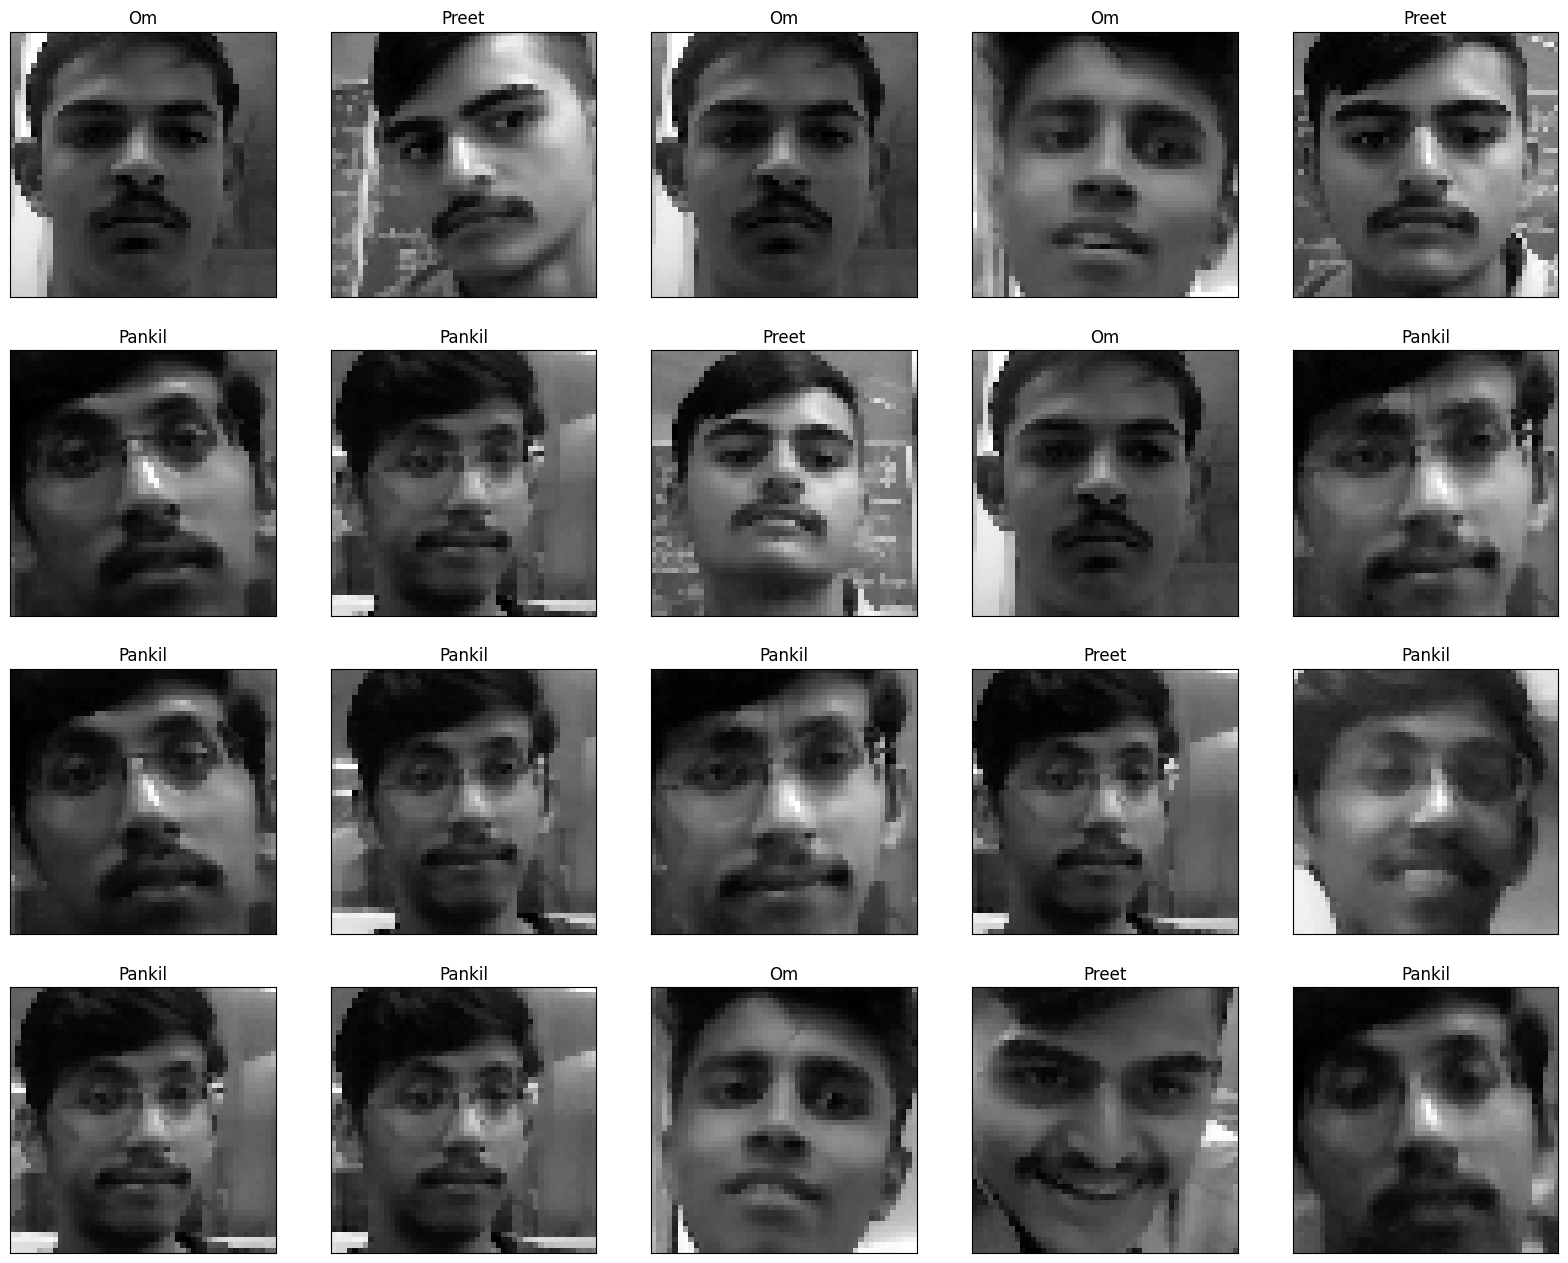

In [48]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20,20))
for num ,data in enumerate(Vdata[:20]):
    img_data = data[0]
    y = fig.add_subplot(5,5,num+1)
    image = img_data
    data = img_data.reshape(-1,50,50,1)
    model_out = model.predict([data][0])
    # add according to data
 
    if np.argmax(model_out) == 0:
        my_label="Name of Person1"
    elif np.argmax(model_out) == 1 :
        my_label="Name of Person2"
    elif np.argmax(model_out) ==2:    
        my_label="Name of Person3"
    elif np.argmax(model_out)==3:
        my_label="Name of Person4"
   

    y.imshow(image,cmap='gray')
    plt.title(my_label)

    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)

plt.show()